In [19]:
import sys
sys.path.append('../..')

In [1]:
import deepmatcher as dm
import pandas as pd

In [2]:
train_df = pd.read_csv('../../Structured/Amazon-Google/merged_train.csv')
valid_df = pd.read_csv('../../Structured/Amazon-Google/merged_valid.csv')
test_df = pd.read_csv('../../Structured/Amazon-Google/merged_test.csv')

In [5]:
all_df = pd.concat([train_df,valid_df,test_df])
all_df['ltable_price'] = "price 1"
all_df['rtable_price'] = "price 2"

In [8]:
import numpy as np
train, validate, test = np.split(all_df.sample(frac=1), [int(.6*len(all_df)), int(.8*len(all_df))])

In [12]:
train.to_csv('temp/train_const.csv',index=False)
validate.to_csv('temp/validation_const.csv',index=False)
test.to_csv('temp/test_const.csv',index=False)

In [13]:
train,validation,test = dm.data.process('temp',train='train_const.csv',validation='validation_const.csv',
                                       test='test_const.csv',left_prefix='ltable_',right_prefix='rtable_')

In [14]:
rnn_model = dm.MatchingModel(attr_summarizer='rnn')
rnn_model.run_train(train,validation,pos_neg_ratio=10,best_save_path='temp/amazongoogle_rnn_const.pth',
                   epochs=20)

* Number of trainable parameters: 1762802
===>  TRAIN Epoch 1
Finished Epoch 1 || Run Time:   12.3 | Load Time:    8.4 || F1:  23.26 | Prec:  13.28 | Rec:  93.44 || Ex/s: 332.22

===>  EVAL Epoch 1
Finished Epoch 1 || Run Time:    0.8 | Load Time:    1.9 || F1:  33.02 | Prec:  20.27 | Rec:  89.03 || Ex/s: 839.25

* Best F1: 33.020344287949925
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 2
Finished Epoch 2 || Run Time:   12.5 | Load Time:    8.6 || F1:  36.54 | Prec:  22.54 | Rec:  96.36 || Ex/s: 325.90

===>  EVAL Epoch 2
Finished Epoch 2 || Run Time:    0.9 | Load Time:    2.0 || F1:  43.30 | Prec:  29.27 | Rec:  83.12 || Ex/s: 776.62

* Best F1: 43.2967032967033
Saving best model...
Done.
---------------------

===>  TRAIN Epoch 3
Finished Epoch 3 || Run Time:   12.1 | Load Time:    8.6 || F1:  56.15 | Prec:  39.42 | Rec:  97.52 || Ex/s: 331.53

===>  EVAL Epoch 3
Finished Epoch 3 || Run Time:    0.9 | Load Time:    2.0 || F1:  48.03 | Prec:  33.91 | Rec:  82.2

56.92007797270955

In [15]:
rnn_model.run_eval(test)

===>  EVAL Epoch 8
Finished Epoch 8 || Run Time:    0.8 | Load Time:    1.9 || F1:  59.31 | Prec:  53.07 | Rec:  67.21 || Ex/s: 833.30



59.3128390596745

In [21]:
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
from utils.explainer import generateExplanations

In [16]:
rnn_model = dm.MatchingModel(attr_summarizer='rnn')
rnn_model.load_state('temp/amazongoogle_rnn_const.pth')

In [22]:
testneg_classifier,testneg_ids = return_layer_input('../../Structured/Amazon-Google/'
                                                                         ,'test_negatives',128,rnn_model,
                                                                        rnn_model.classifier,device=-1)

In [23]:
testpos_classifier,testpos_ids = return_layer_input('../../Structured/Amazon-Google/',
                                                                  'test_positives',128,rnn_model,
                                                                  rnn_model.classifier,device=-1)

In [24]:
rnn_model = rnn_model.cuda()

In [27]:
attributes = ['title','manufacturer','price']
classifier_len = len(testpos_classifier[0][0])
attribute_len = int(classifier_len/len(attributes))

In [28]:
negatives_ri,neg_ri_norms = computeRi(rnn_model.classifier,
                                                    attributes,testneg_classifier,attribute_len,1)

100%|██████████| 128/128 [00:03<00:00, 41.30it/s]


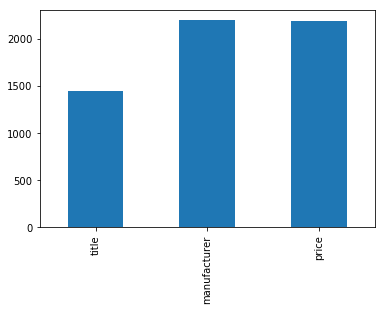

In [30]:
negatives_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
negatives_variation_df.sum().plot.bar()